# A2 SVM # 

In [273]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [274]:
import matplotlib.pyplot as plt
import ast
import pprint

In [275]:
# Load your data
train_dataset = pd.read_csv('/Users/hanshitang/Documents/ML/A2/train_dataset.csv')
test_dataset = pd.read_csv('/Users/hanshitang/Documents/ML/A2/test_dataset.csv')

In [276]:
train_dataset

,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality,imdb_score_binned
0,1,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,Adventure|Animation|Drama|Family|Musical,...,656,English,USA,G,1994,886,17000,[-4.1984697e-03 4.2941985e-03 -1.1961063e-03 ...,0.001576,4
1,2,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,Horror,...,662,English,Canada,R,2005,529,0,[-4.7586653e-03 2.6511205e-03 -3.7954253e-04 ...,0.000675,2
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,Drama,...,118,English,USA,R,2013,1000,11000,[ 2.78131524e-03 -3.15494463e-03 -6.38332494e-...,0.003002,2
3,4,John Carpenter,297,109,0,145,Richard Masur,957,13782838,Horror|Mystery|Sci-Fi,...,911,English,USA,R,1982,163,23000,[-5.32674184e-03 3.60742491e-03 7.91795843e-...,0.001726,4
4,5,Peter Jackson,297,171,0,857,Orlando Bloom,16000,313837577,Action|Adventure|Drama|Fantasy,...,5060,English,New Zealand,PG-13,2001,5000,21000,[-4.2586620e-03 3.6257182e-03 -1.5326265e-03 ...,0.001876,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,3000,Ken Kwapis,161,129,42,49,Sabrina Revelle,97,93952276,Comedy|Drama|Romance,...,203,English,USA,PG-13,2009,50,12000,[-2.3482253e-03 4.0821606e-04 -4.6702172e-04 ...,0.000750,2
3000,3001,Ron Howard,393,123,2000,471,Olivia Wilde,26000,26903709,Action|Biography|Drama|Sport,...,475,English,UK,R,2013,10000,83000,[ 1.6231873e-03 -4.9172580e-04 3.6536737e-03 ...,0.003302,4
3001,3002,F. Gary Gray,216,118,473,963,Leslie Bibb,18000,73343413,Crime|Drama|Thriller,...,429,English,USA,R,2009,1000,21000,[-1.0675089e-03 1.7000491e-03 -2.9880603e-04 ...,0.003302,3
3002,3003,Nadine Labaki,109,95,0,0,Adel Karam,227,1060591,Comedy|Drama|Romance,...,66,Arabic,France,PG,2007,4,0,[-1.28144643e-03 -1.88259745e-03 1.82478712e-...,0.000300,3


In [277]:
tmp = train_dataset[['imdb_score_binned', 'genres']].copy()
tmp

,imdb_score_binned,genres
0,4,Adventure|Animation|Drama|Family|Musical
1,2,Horror
2,2,Drama
3,4,Horror|Mystery|Sci-Fi
4,4,Action|Adventure|Drama|Fantasy
...,...,...
2999,2,Comedy|Drama|Romance
3000,4,Action|Biography|Drama|Sport
3001,3,Crime|Drama|Thriller
3002,3,Comedy|Drama|Romance


In [278]:
tmp['genres_split'] = tmp['genres'].str.split('|')
tmp.drop(columns=['genres'], inplace=True)

In [279]:
tmp

,imdb_score_binned,genres_split
0,4,"[Adventure, Animation, Drama, Family, Musical]"
1,2,[Horror]
2,2,[Drama]
3,4,"[Horror, Mystery, Sci-Fi]"
4,4,"[Action, Adventure, Drama, Fantasy]"
...,...,...
2999,2,"[Comedy, Drama, Romance]"
3000,4,"[Action, Biography, Drama, Sport]"
3001,3,"[Crime, Drama, Thriller]"
3002,3,"[Comedy, Drama, Romance]"


In [280]:
tmp = tmp.explode('genres_split')
tmp

,imdb_score_binned,genres_split
0,4,Adventure
0,4,Animation
0,4,Drama
0,4,Family
0,4,Musical
...,...,...
3002,3,Comedy
3002,3,Drama
3002,3,Romance
3003,3,Comedy


In [281]:
tmp['genres_split'].value_counts()

genres_split
Drama          1505
Comedy         1175
Thriller        884
Action          765
Romance         699
Adventure       612
Crime           568
Fantasy         405
Sci-Fi          388
Family          354
Horror          321
Mystery         306
Biography       194
Animation       146
War             127
Music           126
History         125
Sport           114
Musical          79
Western          41
Documentary      37
Film-Noir         1
Name: count, dtype: int64

In [282]:
tmp_agg = tmp.groupby(['genres_split'])['imdb_score_binned'].agg(['mean', 'size']).reset_index()

tmp_agg.columns = ['genres_split', 'mean_imdb_score', 'film_count']

tmp_agg

,genres_split,mean_imdb_score,film_count
0,Action,2.143791,765
1,Adventure,2.233660,612
2,Animation,2.376712,146
3,Biography,2.664948,194
4,Comedy,2.080851,1175
5,Crime,2.290493,568
6,Documentary,2.648649,37
7,Drama,2.433223,1505
8,Family,2.098870,354
9,Fantasy,2.155556,405


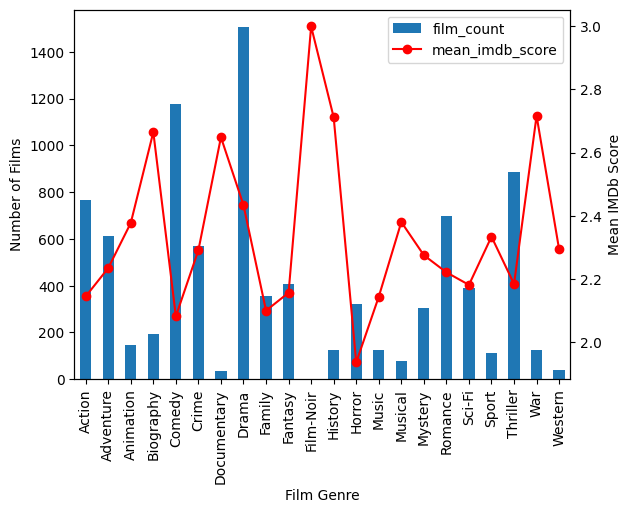

In [283]:
# Plotting film count
ax = tmp_agg['film_count'].plot(kind='bar', label='film_count', legend=True, use_index=False)
ax.set_xticks(range(len(tmp_agg)))
ax.set_xticklabels(tmp_agg['genres_split'])
ax.set_xlabel('Film Genre')
ax.set_ylabel('Number of Films')

# Adding mean IMDb score on the right-hand side
ax2 = ax.twinx()
ax2.plot(tmp_agg.index, tmp_agg['mean_imdb_score'], color='r', marker='o', label='mean_imdb_score')
ax2.set_ylabel('Mean IMDb Score')

# Adjusting legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()


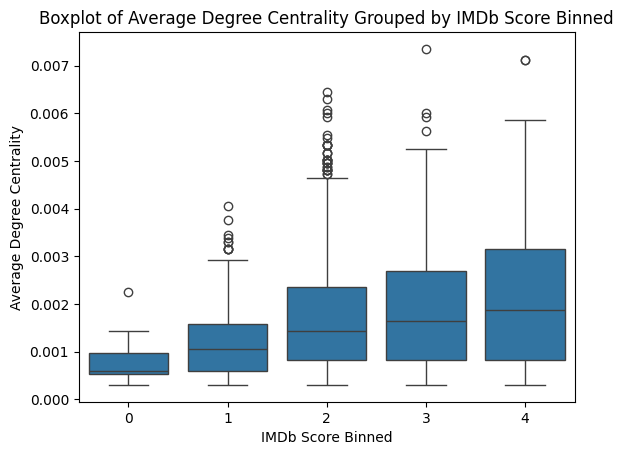

In [284]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting boxplot
sns.boxplot(x='imdb_score_binned', y='average_degree_centrality', data=train_dataset)
plt.xlabel('IMDb Score Binned')
plt.ylabel('Average Degree Centrality')
plt.title('Boxplot of Average Degree Centrality Grouped by IMDb Score Binned')
plt.show()

## Preprocessing ##

In [285]:
# Prepare features and target
train_X = train_dataset.drop(columns=['imdb_score_binned'])
train_y = train_dataset['imdb_score_binned']

In [286]:
train_X

,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,plot_keywords,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality
0,1,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,Adventure|Animation|Drama|Family|Musical,...,king|prince|scar|uncle|unnecessary guilt,656,English,USA,G,1994,886,17000,[-4.1984697e-03 4.2941985e-03 -1.1961063e-03 ...,0.001576
1,2,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,Horror,...,apocalypse|mercenary|skyscraper|urban setting|...,662,English,Canada,R,2005,529,0,[-4.7586653e-03 2.6511205e-03 -3.7954253e-04 ...,0.000675
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,Drama,...,alcoholic|cigarette smoking|father son relatio...,118,English,USA,R,2013,1000,11000,[ 2.78131524e-03 -3.15494463e-03 -6.38332494e-...,0.003002
3,4,John Carpenter,297,109,0,145,Richard Masur,957,13782838,Horror|Mystery|Sci-Fi,...,alien creature|alien life form|antarctica|isol...,911,English,USA,R,1982,163,23000,[-5.32674184e-03 3.60742491e-03 7.91795843e-...,0.001726
4,5,Peter Jackson,297,171,0,857,Orlando Bloom,16000,313837577,Action|Adventure|Drama|Fantasy,...,elf|hobbit|middle earth|quest|ring,5060,English,New Zealand,PG-13,2001,5000,21000,[-4.2586620e-03 3.6257182e-03 -1.5326265e-03 ...,0.001876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,3000,Ken Kwapis,161,129,42,49,Sabrina Revelle,97,93952276,Comedy|Drama|Romance,...,advertising|bar|dating|lingerie slip|six word ...,203,English,USA,PG-13,2009,50,12000,[-2.3482253e-03 4.0821606e-04 -4.6702172e-04 ...,0.000750
3000,3001,Ron Howard,393,123,2000,471,Olivia Wilde,26000,26903709,Action|Biography|Drama|Sport,...,1970s|female rear nudity|formula 1|rivalry|sex...,475,English,UK,R,2013,10000,83000,[ 1.6231873e-03 -4.9172580e-04 3.6536737e-03 ...,0.003302
3001,3002,F. Gary Gray,216,118,473,963,Leslie Bibb,18000,73343413,Crime|Drama|Thriller,...,attorney|deal|district attorney|investigation|...,429,English,USA,R,2009,1000,21000,[-1.0675089e-03 1.7000491e-03 -2.9880603e-04 ...,0.003302
3002,3003,Nadine Labaki,109,95,0,0,Adel Karam,227,1060591,Comedy|Drama|Romance,...,caramel|friendship|police|secret|suitor,66,Arabic,France,PG,2007,4,0,[-1.28144643e-03 -1.88259745e-03 1.82478712e-...,0.000300


In [287]:
train_y

0       4
1       2
2       2
3       4
4       4
       ..
2999    2
3000    4
3001    3
3002    3
3003    3
Name: imdb_score_binned, Length: 3004, dtype: int64

## Check Null value

In [288]:
train_X.isnull().sum()

id                           0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
num_user_for_reviews         0
language                     1
country                      0
content_rating               0
title_year                   0
actor_2_facebook_likes       0
movie_facebook_likes         0
title_embedding              0
average_degree_centrality    0
dtype: int64

In [289]:
train_X[train_X['language'].isnull()]

,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,plot_keywords,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality
2787,2788,Ron Fricke,115,102,330,0,Balinese Tari Legong Dancers,48,2601847,Documentary|Music,...,hall of mirrors|mont saint michel france|palac...,69,NaN,USA,PG-13,2011,0,26000,[-1.7939140e-04 1.7596362e-03 -8.5148757e-05 ...,0.0003


In [290]:
test_dataset.isnull().sum()

id                           0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
title_year                   0
actor_2_facebook_likes       0
movie_facebook_likes         0
title_embedding              0
average_degree_centrality    0
dtype: int64

### New English feature

In [291]:
train_X['English'] = train_X['language'].map(lambda x: 1 if (x == 'English') else 0)
test_dataset['English'] = test_dataset['language'].map(lambda x: 1 if (x == 'English') else 0)

### Country ###

In [292]:
countries = ['USA', 'UK', 'France', 'Germany', 'Canada', 'Australia', 'Spain', 'Japan', 'New Zealand', 'China', 'Hong Kong' , 'Italy']

for country in countries:
    train_X[country] = train_X['country'].map(lambda x: 1 if (x == country) else 0)
    test_dataset[country] = test_dataset['country'].map(lambda x: 1 if (x == country) else 0)

In [293]:
train_X

,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,France,Germany,Canada,Australia,Spain,Japan,New Zealand,China,Hong Kong,Italy
0,1,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,Adventure|Animation|Drama|Family|Musical,...,0,0,0,0,0,0,0,0,0,0
1,2,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,Horror,...,0,0,1,0,0,0,0,0,0,0
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,Drama,...,0,0,0,0,0,0,0,0,0,0
3,4,John Carpenter,297,109,0,145,Richard Masur,957,13782838,Horror|Mystery|Sci-Fi,...,0,0,0,0,0,0,0,0,0,0
4,5,Peter Jackson,297,171,0,857,Orlando Bloom,16000,313837577,Action|Adventure|Drama|Fantasy,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,3000,Ken Kwapis,161,129,42,49,Sabrina Revelle,97,93952276,Comedy|Drama|Romance,...,0,0,0,0,0,0,0,0,0,0
3000,3001,Ron Howard,393,123,2000,471,Olivia Wilde,26000,26903709,Action|Biography|Drama|Sport,...,0,0,0,0,0,0,0,0,0,0
3001,3002,F. Gary Gray,216,118,473,963,Leslie Bibb,18000,73343413,Crime|Drama|Thriller,...,0,0,0,0,0,0,0,0,0,0
3002,3003,Nadine Labaki,109,95,0,0,Adel Karam,227,1060591,Comedy|Drama|Romance,...,1,0,0,0,0,0,0,0,0,0


In [294]:
test_dataset

,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,France,Germany,Canada,Australia,Spain,Japan,New Zealand,China,Hong Kong,Italy
0,1,Angelo Pizzo,27,118,14,400,Finn Wittrock,2000,2246000,Biography|Drama|Sport,...,0,0,0,0,0,0,0,0,0,0
1,2,Oliver Stone,339,141,0,404,Shea Whigham,749,47307550,Crime|Drama|Thriller,...,0,0,0,0,0,0,0,0,0,0
2,3,Peter Stebbings,78,95,89,388,Tony Nappo,963,37606,Comedy|Crime|Drama,...,0,0,1,0,0,0,0,0,0,0
3,4,Sam Mendes,226,117,0,818,Jennifer Jason Leigh,15000,104054514,Crime|Drama|Thriller,...,0,0,0,0,0,0,0,0,0,0
4,5,Maggie Carey,97,104,38,690,Alia Shawkat,801,3447339,Comedy|Romance,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,748,Wes Anderson,179,93,0,766,Connie Nielsen,13000,17096053,Comedy|Drama,...,0,0,0,0,0,0,0,0,0,0
748,749,Timur Bekmambetov,393,105,335,911,Dominic Cooper,3000,37516013,Action|Fantasy|Horror,...,0,0,0,0,0,0,0,0,0,0
749,750,James Ivory,55,117,133,249,Rupert Graves,687,20966644,Drama|Romance,...,0,0,0,0,0,0,0,0,0,0
750,751,Steve Trenbirth,85,72,0,384,Phil Collins,3000,47887943,Adventure|Animation|Family|Musical,...,0,0,0,0,0,0,0,0,0,0


### Rating ##
Hot encode after standardizing or categorizing content ratings into more manageable categories

In [295]:
train_X['content_rating'] = train_X['content_rating'].map(lambda x: 'PG' if (x == 'GP' or x == 'M') else x)
train_X['content_rating'] = train_X['content_rating'].map(lambda x: 'Unrated' if (x == 'Not Rated' or x == 'Passed' or x == 'Approved') else x)
train_X['content_rating'] = train_X['content_rating'].map(lambda x: 'NC-17' if (x == 'X') else x)

test_dataset['content_rating'] = test_dataset['content_rating'].map(lambda x: 'PG' if (x == 'GP' or x == 'M') else x)
test_dataset['content_rating'] = test_dataset['content_rating'].map(lambda x: 'Unrated' if (x == 'Not Rated' or x == 'Passed' or x == 'Approved') else x)
test_dataset['content_rating'] = test_dataset['content_rating'].map(lambda x: 'NC-17' if (x == 'X') else x)

In [296]:
ratings = list(train_X['content_rating'].unique())

for rating in ratings:
    train_X[rating] = train_X['content_rating'].map(lambda x: 1 if (x == rating) else 0)
    test_dataset[rating] = test_dataset['content_rating'].map(lambda x: 1 if (x == rating) else 0)

### Director Degree Centrality ###

In [297]:
director_counts_dict = train_X['director_name'].value_counts().to_dict()
number_of_movies = train_X.shape[0]

train_X['director_degree_centrality'] = train_X['director_name'].map(lambda x: (director_counts_dict.get(x) - 1) / (number_of_movies - 1))
test_dataset['director_degree_centrality'] = test_dataset['director_name'].map(lambda x: max(0, (director_counts_dict.get(x, 0) - 1) / (number_of_movies - 1)))

### Treating Abstract columns ###
loading data from a numpy file, converting it to a DataFrame, and optionally renaming columns.

In [298]:
test_countvec_features_actor_1_name_df = pd.DataFrame(np.load('features_countvec/test_countvec_features_actor_1_name.npy'))

train_countvec_features_actor_1_name_df = pd.DataFrame(np.load('features_countvec/train_countvec_features_actor_1_name.npy'))

test_countvec_features_actor_2_name_df = pd.DataFrame(np.load('features_countvec/test_countvec_features_actor_2_name.npy'))

train_countvec_features_actor_2_name_df = pd.DataFrame(np.load('features_countvec/train_countvec_features_actor_2_name.npy'))

test_countvec_features_director_name_df = pd.DataFrame(np.load('features_countvec/test_countvec_features_actor_2_name.npy'))

train_countvec_features_director_name_df = pd.DataFrame(np.load('features_countvec/train_countvec_features_director_name.npy'))

test_doc2vec_features_genre_df = pd.DataFrame(np.load('features_doc2vec/test_doc2vec_features_genre.npy'))
test_doc2vec_features_genre_df = test_doc2vec_features_genre_df.rename(columns={i: f"genre_vec_{i}" for i in  range(100)})

train_doc2vec_features_genre_df = pd.DataFrame(np.load('features_doc2vec/train_doc2vec_features_genre.npy'))
train_doc2vec_features_genre_df = train_doc2vec_features_genre_df.rename(columns={i: f"genre_vec_{i}" for i in  range(100)})

test_doc2vec_features_plot_keywords_df = pd.DataFrame(np.load('features_doc2vec/test_doc2vec_features_plot_keywords.npy'))
test_doc2vec_features_plot_keywords_df = test_doc2vec_features_plot_keywords_df.rename(columns={i: f"plot_keywords_vec_{i}" for i in  range(100)})

train_doc2vec_features_plot_keywords_df = pd.DataFrame(np.load('features_doc2vec/train_doc2vec_features_plot_keywords.npy'))
train_doc2vec_features_plot_keywords_df = train_doc2vec_features_plot_keywords_df.rename(columns={i: f"plot_keywords_vec_{i}" for i in  range(100)})

test_fasttext_title_embeddings_df = pd.DataFrame(np.load('features_fasttext/test_fasttext_title_embeddings.npy'))
test_fasttext_title_embeddings_df = test_fasttext_title_embeddings_df.rename(columns={i: f"test_fasttext_title_vec_{i}" for i in  range(100)})

train_fasttext_title_embeddings_df = pd.DataFrame(np.load('features_fasttext/train_fasttext_title_embeddings.npy'))
train_fasttext_title_embeddings_df = train_fasttext_title_embeddings_df.rename(columns={i: f"test_fasttext_title_vec_{i}" for i in  range(100)})

### PCA ### 
separately to the Doc2Vec features for genres and plot keywords, as well as to the FastText embeddings for movie titles.

In [299]:
from sklearn.decomposition import PCA

n = 10

pca = PCA(n_components=n)
train_doc2vec_features_genre_df = pd.DataFrame(pca.fit_transform(train_doc2vec_features_genre_df))
train_doc2vec_features_genre_df = train_doc2vec_features_genre_df.rename(columns={i: f"genre_PCA_vec_{i}" for i in  range(n)})
test_doc2vec_features_genre_df = pd.DataFrame(pca.transform(test_doc2vec_features_genre_df))
test_doc2vec_features_genre_df = test_doc2vec_features_genre_df.rename(columns={i: f"genre_PCA_vec_{i}" for i in  range(n)})

pca = PCA(n_components=n)
train_doc2vec_features_plot_keywords_df = pd.DataFrame(pca.fit_transform(train_doc2vec_features_plot_keywords_df))
train_doc2vec_features_plot_keywords_df = train_doc2vec_features_plot_keywords_df.rename(columns={i: f"plot_keywords_PCA_vec_{i}" for i in  range(n)})
test_doc2vec_features_plot_keywords_df = pd.DataFrame(pca.transform(test_doc2vec_features_plot_keywords_df))
test_doc2vec_features_plot_keywords_df = test_doc2vec_features_plot_keywords_df.rename(columns={i: f"plot_keywords_PCA_vec_{i}" for i in  range(n)})

pca = PCA(n_components=n)
train_fasttext_title_embeddings_df = pd.DataFrame(pca.fit_transform(train_fasttext_title_embeddings_df))
train_fasttext_title_embeddings_df = train_fasttext_title_embeddings_df.rename(columns={i: f"title_PCA_vec_{i}" for i in  range(n)})
test_fasttext_title_embeddings_df = pd.DataFrame(pca.transform(test_fasttext_title_embeddings_df))
test_fasttext_title_embeddings_df = test_fasttext_title_embeddings_df.rename(columns={i: f"title_PCA_vec_{i}" for i in  range(n)})

dropping include 'id', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'genres', 'movie_title', 'plot_keywords', 'language', 'country', 'content_rating', and 'title_embedding'.



In [300]:
train_X = train_X.drop(columns = ['id', 'director_name', 'actor_1_name', 'actor_2_name' , 'actor_3_name', 'genres', 'movie_title', 'plot_keywords', 'language', 'country', 'content_rating', 'title_embedding'])
test_dataset = test_dataset.drop(columns = ['id', 'director_name', 'actor_1_name', 'actor_2_name' , 'actor_3_name', 'genres', 'movie_title', 'plot_keywords', 'language', 'country', 'content_rating', 'title_embedding'])

In [301]:
train_X

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,China,Hong Kong,Italy,G,R,PG-13,Unrated,PG,NC-17,director_degree_centrality
0,186,73,28,847,2000,422783777,644348,6458,0,656,...,0,0,0,1,0,0,0,0,0,0.000333
1,252,97,0,233,654,20433940,78883,1876,8,662,...,0,0,0,0,1,0,0,0,0,0.000000
2,232,117,234,221,12000,371897,36494,13607,2,118,...,0,0,0,0,1,0,0,0,0,0.000999
3,297,109,0,145,957,13782838,258078,1757,0,911,...,0,0,0,0,1,0,0,0,0,0.002997
4,297,171,0,857,16000,313837577,1238746,22342,2,5060,...,0,0,0,0,0,1,0,0,0,0.002997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,161,129,42,49,97,93952276,132048,318,7,203,...,0,0,0,0,0,1,0,0,0,0.000999
3000,393,123,2000,471,26000,26903709,312629,37206,0,475,...,0,0,0,0,1,0,0,0,0,0.003330
3001,216,118,473,963,18000,73343413,217480,22517,0,429,...,0,0,0,0,1,0,0,0,0,0.002331
3002,109,95,0,0,227,1060591,9750,231,0,66,...,0,0,0,0,0,0,0,1,0,0.000000


In [302]:
train_X.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes',
       'movie_facebook_likes', 'average_degree_centrality', 'English', 'USA',
       'UK', 'France', 'Germany', 'Canada', 'Australia', 'Spain', 'Japan',
       'New Zealand', 'China', 'Hong Kong', 'Italy', 'G', 'R', 'PG-13',
       'Unrated', 'PG', 'NC-17', 'director_degree_centrality'],
      dtype='object')

### Train/ Test joined
renamed columns appropriately after loading these features and are now joining them with your existing training and test datasets. 

In [303]:
train_X_joined = pd.concat([train_X, train_doc2vec_features_genre_df, train_doc2vec_features_plot_keywords_df,train_fasttext_title_embeddings_df], axis=1)
test_X_joined = pd.concat([test_dataset, test_doc2vec_features_genre_df, test_doc2vec_features_plot_keywords_df,test_fasttext_title_embeddings_df], axis=1)

In [304]:
test_countvec_features_actor_1_name_df = pd.DataFrame(np.load('features_countvec/test_countvec_features_actor_1_name.npy'))

train_countvec_features_actor_1_name_df = pd.DataFrame(np.load('features_countvec/train_countvec_features_actor_1_name.npy'))

test_countvec_features_actor_2_name_df = pd.DataFrame(np.load('features_countvec/test_countvec_features_actor_2_name.npy'))

train_countvec_features_actor_2_name_df = pd.DataFrame(np.load('features_countvec/train_countvec_features_actor_2_name.npy'))

test_countvec_features_director_name_df = pd.DataFrame(np.load('features_countvec/test_countvec_features_actor_2_name.npy'))

train_countvec_features_director_name_df = pd.DataFrame(np.load('features_countvec/train_countvec_features_director_name.npy'))

test_doc2vec_features_genre_df = pd.DataFrame(np.load('features_doc2vec/test_doc2vec_features_genre.npy'))
test_doc2vec_features_genre_df = test_doc2vec_features_genre_df.rename(columns={i: f"genre_vec_{i}" for i in  range(100)})

train_doc2vec_features_genre_df = pd.DataFrame(np.load('features_doc2vec/train_doc2vec_features_genre.npy'))
train_doc2vec_features_genre_df = train_doc2vec_features_genre_df.rename(columns={i: f"genre_vec_{i}" for i in  range(100)})

test_doc2vec_features_plot_keywords_df = pd.DataFrame(np.load('features_doc2vec/test_doc2vec_features_plot_keywords.npy'))
test_doc2vec_features_plot_keywords_df = test_doc2vec_features_plot_keywords_df.rename(columns={i: f"plot_keywords_vec_{i}" for i in  range(100)})

train_doc2vec_features_plot_keywords_df = pd.DataFrame(np.load('features_doc2vec/train_doc2vec_features_plot_keywords.npy'))
train_doc2vec_features_plot_keywords_df = train_doc2vec_features_plot_keywords_df.rename(columns={i: f"plot_keywords_vec_{i}" for i in  range(100)})

test_fasttext_title_embeddings_df = pd.DataFrame(np.load('features_fasttext/test_fasttext_title_embeddings.npy'))
test_fasttext_title_embeddings_df = test_fasttext_title_embeddings_df.rename(columns={i: f"test_fasttext_title_vec_{i}" for i in  range(100)})

train_fasttext_title_embeddings_df = pd.DataFrame(np.load('features_fasttext/train_fasttext_title_embeddings.npy'))
train_fasttext_title_embeddings_df = train_fasttext_title_embeddings_df.rename(columns={i: f"test_fasttext_title_vec_{i}" for i in  range(100)})

In [305]:
train_X_joined_total = pd.concat([train_X, train_doc2vec_features_genre_df, train_doc2vec_features_plot_keywords_df,train_fasttext_title_embeddings_df], axis=1)
test_X_joined_total = pd.concat([test_dataset, test_doc2vec_features_genre_df, test_doc2vec_features_plot_keywords_df,test_fasttext_title_embeddings_df], axis=1)

In [306]:
train_X_joined_total

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,test_fasttext_title_vec_90,test_fasttext_title_vec_91,test_fasttext_title_vec_92,test_fasttext_title_vec_93,test_fasttext_title_vec_94,test_fasttext_title_vec_95,test_fasttext_title_vec_96,test_fasttext_title_vec_97,test_fasttext_title_vec_98,test_fasttext_title_vec_99
0,186,73,28,847,2000,422783777,644348,6458,0,656,...,0.004746,0.003770,0.001390,0.003076,-0.008132,0.001598,0.006643,0.002400,-0.003933,-0.005527
1,252,97,0,233,654,20433940,78883,1876,8,662,...,0.005036,0.003941,0.003205,0.001162,-0.005804,0.002159,0.003575,-0.000710,-0.003438,-0.006788
2,232,117,234,221,12000,371897,36494,13607,2,118,...,-0.000173,0.000985,-0.004908,0.000435,0.002376,0.000944,0.003305,0.000132,-0.002589,-0.002180
3,297,109,0,145,957,13782838,258078,1757,0,911,...,0.005158,0.005430,0.003289,0.002486,-0.010253,0.003423,0.006926,0.001835,-0.005065,-0.008602
4,297,171,0,857,16000,313837577,1238746,22342,2,5060,...,0.004583,0.005102,0.002862,0.000808,-0.007791,0.002772,0.005651,-0.000516,-0.004016,-0.006797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,161,129,42,49,97,93952276,132048,318,7,203,...,0.001290,0.002782,-0.000041,0.001678,-0.002992,-0.000076,0.002639,-0.000180,-0.001575,-0.002464
3000,393,123,2000,471,26000,26903709,312629,37206,0,475,...,0.000591,-0.000388,0.001460,-0.000175,-0.000439,0.000435,-0.000345,0.003004,0.000988,-0.001010
3001,216,118,473,963,18000,73343413,217480,22517,0,429,...,-0.000081,0.001027,-0.000284,0.000425,-0.000426,0.000349,0.002354,0.000964,-0.000928,-0.000762
3002,109,95,0,0,227,1060591,9750,231,0,66,...,-0.001824,0.001365,-0.000980,-0.000108,-0.002340,0.002191,0.000235,0.000919,-0.000518,-0.001860


In [307]:
test_X_joined_total

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,test_fasttext_title_vec_90,test_fasttext_title_vec_91,test_fasttext_title_vec_92,test_fasttext_title_vec_93,test_fasttext_title_vec_94,test_fasttext_title_vec_95,test_fasttext_title_vec_96,test_fasttext_title_vec_97,test_fasttext_title_vec_98,test_fasttext_title_vec_99
0,27,118,14,400,2000,2246000,2302,3384,4,20,...,-0.000023,0.002233,-0.001463,0.002111,-0.001449,0.000483,0.002822,-0.001277,-0.002323,-0.001911
1,339,141,0,404,749,47307550,104301,1948,4,269,...,0.000812,0.003193,0.001175,0.001316,-0.001595,0.002132,0.001770,-0.000132,0.000088,0.001170
2,78,95,89,388,963,37606,31836,2658,0,90,...,0.002194,0.000918,-0.000543,0.000038,0.001010,0.001043,-0.000967,-0.000825,-0.001011,-0.000787
3,226,117,0,818,15000,104054514,200359,16828,0,1009,...,0.001673,0.000719,-0.000135,0.001563,-0.002141,-0.000219,0.001899,0.000988,-0.000454,-0.002536
4,97,104,38,690,801,3447339,29517,2667,7,79,...,0.003995,0.004481,0.002086,0.000519,-0.004923,-0.001050,0.003928,0.000649,-0.004242,-0.003169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,179,93,0,766,13000,17096053,134458,15716,2,640,...,0.001266,-0.000992,-0.001771,0.001414,-0.002169,0.000809,-0.001234,0.002136,-0.000352,0.000923
748,393,105,335,911,3000,37516013,128629,8281,0,348,...,0.000949,0.000580,-0.000518,0.000270,-0.001251,0.000496,0.000894,0.000664,-0.000984,-0.000902
749,55,117,133,249,687,20966644,29610,1665,0,94,...,0.001233,0.004195,0.000933,-0.000042,-0.001694,0.003148,0.002366,0.000629,-0.001091,-0.004242
750,85,72,0,384,3000,47887943,11634,4480,0,58,...,0.003388,0.004836,0.001195,0.001547,-0.005353,0.003031,0.002243,-0.000540,-0.002655,-0.003890


### linearizing features in your dataset

columns have been logarithmically transformed to linearize their relationships with the target variable or to account for non-linear growth patterns in the data.



In [308]:
transformed_train_X_joined = train_X_joined[['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes',
       'num_user_for_reviews', 'actor_2_facebook_likes',
       'movie_facebook_likes']].apply(np.log1p)

In [309]:
transformed_test_X_joined = test_X_joined[['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes',
       'num_user_for_reviews', 'actor_2_facebook_likes',
       'movie_facebook_likes']].apply(np.log1p)

In [310]:
train_X_joined[['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes',
       'num_user_for_reviews', 'actor_2_facebook_likes',
       'movie_facebook_likes']] = transformed_train_X_joined[['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes',
       'num_user_for_reviews', 'actor_2_facebook_likes',
       'movie_facebook_likes']]

In [311]:
test_X_joined[['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes',
       'num_user_for_reviews', 'actor_2_facebook_likes',
       'movie_facebook_likes']] = transformed_test_X_joined[['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes',
       'num_user_for_reviews', 'actor_2_facebook_likes',
       'movie_facebook_likes']]

In [312]:
train_X_joined

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,title_PCA_vec_0,title_PCA_vec_1,title_PCA_vec_2,title_PCA_vec_3,title_PCA_vec_4,title_PCA_vec_5,title_PCA_vec_6,title_PCA_vec_7,title_PCA_vec_8,title_PCA_vec_9
0,5.231109,4.304065,3.367296,6.742881,7.601402,19.862371,13.375996,8.773230,0,6.487684,...,0.023998,0.001312,-0.000837,0.000499,0.000677,-0.000230,0.000613,-0.002675,0.001720,-0.000079
1,5.533389,4.584967,0.000000,5.455321,6.484635,16.832708,11.275734,7.537430,8,6.496775,...,0.019316,-0.007272,0.003419,-0.000350,-0.002955,0.001375,0.000914,0.000158,-0.000396,-0.001125
2,5.451038,4.770685,5.459586,5.402677,9.392745,12.826375,10.504931,9.518413,2,4.779123,...,-0.007136,0.000654,-0.001910,-0.000625,0.001944,0.006739,0.001086,0.002606,-0.000063,-0.001379
3,5.697093,4.700480,0.000000,4.983607,6.864848,16.438935,12.461021,7.471932,0,6.815640,...,0.034419,0.001828,-0.002114,-0.000313,0.001821,-0.000081,-0.000612,0.000303,0.001418,-0.000674
4,5.697093,5.147494,0.000000,6.754604,9.680406,19.564386,14.029611,10.014268,2,8.529319,...,0.023694,-0.005019,0.001512,-0.001041,-0.001345,0.000250,-0.001154,-0.000073,0.000367,-0.000877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,5.087596,4.867534,3.761200,3.912023,4.584967,18.358298,11.790928,5.765191,7,5.318120,...,-0.001023,-0.000191,-0.000533,0.001789,0.000429,-0.001161,0.000528,-0.000901,-0.000177,-0.001487
3000,5.976351,4.820282,7.601402,6.156979,10.165890,17.107775,12.652776,10.524252,0,6.165418,...,-0.010964,0.000295,-0.002261,-0.003616,-0.005522,-0.001991,0.000959,0.003338,-0.000532,0.002108
3001,5.379897,4.779123,6.161207,6.871091,9.798183,18.110663,12.289867,10.022070,0,6.063785,...,-0.007822,0.000424,0.000071,0.001027,0.000505,0.000383,0.000440,-0.001918,0.000275,-0.000028
3002,4.700480,4.564348,0.000000,0.000000,5.429346,13.874338,9.185125,5.446737,0,4.204693,...,-0.009005,0.000011,0.000273,-0.001572,0.001888,-0.003730,0.000301,-0.000203,0.001344,-0.001490


In [313]:
test_X_joined

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,title_PCA_vec_0,title_PCA_vec_1,title_PCA_vec_2,title_PCA_vec_3,title_PCA_vec_4,title_PCA_vec_5,title_PCA_vec_6,title_PCA_vec_7,title_PCA_vec_8,title_PCA_vec_9
0,3.332205,4.779123,2.708050,5.993961,7.601402,14.624662,7.741968,8.127109,4,3.044522,...,-0.008142,-0.001034,-0.001191,-0.000644,-0.000480,-0.001511,-0.001612,0.002422,0.000857,-0.000215
1,5.828946,4.955827,0.000000,6.003887,6.620073,17.672180,11.555046,7.575072,4,5.598422,...,-0.009348,0.000365,-0.000015,-0.001405,0.000321,-0.000077,-0.001424,0.001141,-0.000539,-0.000635
2,4.369448,4.564348,4.499810,5.963579,6.871091,10.534945,10.368384,7.885705,0,4.510860,...,-0.011587,0.001481,0.000920,-0.002026,-0.001130,0.000831,-0.000624,0.000072,0.000887,-0.001237
3,5.424950,4.770685,0.000000,6.708084,9.615872,18.460426,12.207871,9.730859,0,6.917706,...,-0.000202,0.002185,-0.000577,0.001281,-0.000201,0.002858,0.004124,-0.002227,-0.002636,-0.002604
4,4.584967,4.653960,3.663562,6.538140,6.687109,15.053113,10.292756,7.889084,7,4.382027,...,0.009897,0.002149,-0.000941,-0.000842,0.000679,-0.000556,-0.000472,0.000939,-0.001323,-0.000083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,5.192957,4.543295,0.000000,6.642487,9.472782,16.654358,11.809015,9.662498,2,6.463029,...,-0.011321,-0.000334,-0.000680,-0.001924,-0.001455,-0.000795,0.000834,0.001910,0.001128,0.000190
748,5.976351,4.663439,5.817111,6.815640,8.006701,17.440278,11.764695,9.021840,0,5.855072,...,-0.008548,0.000729,-0.000680,0.000064,-0.000349,0.000043,-0.000212,0.000640,0.000203,0.000090
749,4.025352,4.770685,4.897840,5.521461,6.533789,16.858443,10.295901,7.418181,0,4.553877,...,0.003177,-0.004024,0.001937,0.001165,0.007636,0.000923,-0.002040,-0.003530,-0.001837,-0.003185
750,4.454347,4.290459,0.000000,5.953243,8.006701,17.684374,9.361773,8.407602,0,4.077537,...,0.013367,0.004719,0.008273,0.000673,-0.002043,-0.001830,-0.000512,0.001409,-0.001322,0.000261


In [314]:
train_y

0       4
1       2
2       2
3       4
4       4
       ..
2999    2
3000    4
3001    3
3002    3
3003    3
Name: imdb_score_binned, Length: 3004, dtype: int64

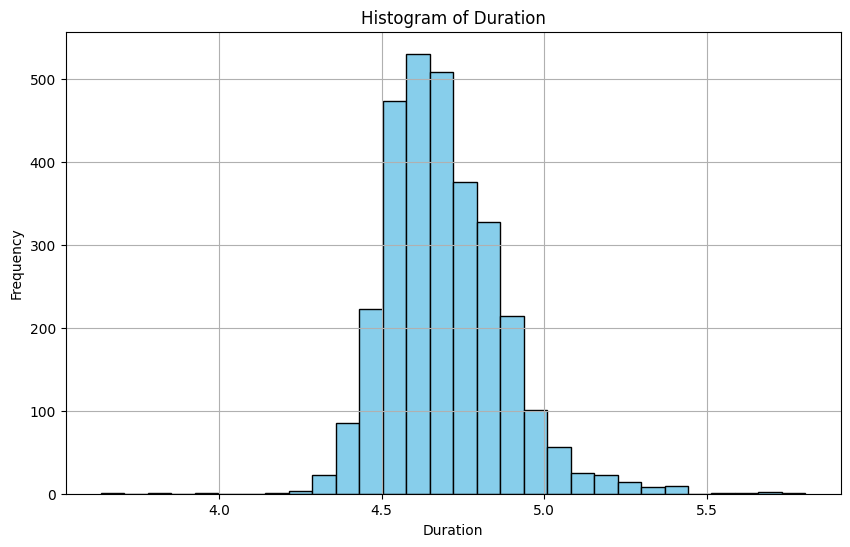

In [315]:
import matplotlib.pyplot as plt

# Assuming train_X_joined and transformed_train_X_joined are defined elsewhere

# Extracting 'duration' feature
duration_data = train_X_joined['duration']

# Plotting histogram
plt.figure(figsize=(10, 6))
plt.hist(duration_data, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Duration')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# SVM #

In [316]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train_X_joined, train_y, test_size=0.2, random_state=999)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM Classifier
svm_model = SVC(kernel='linear', C=1.0, random_state=999)  # 'linear' kernel 

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Predict and evaluate the model
y_pred = svm_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00        49
           2       0.73      0.92      0.81       374
           3       0.62      0.48      0.54       144
           4       1.00      0.64      0.78        28

    accuracy                           0.72       601
   macro avg       0.47      0.41      0.43       601
weighted avg       0.65      0.72      0.67       601



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [317]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train_X_joined, train_y, test_size=0.2, random_state=999)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM Classifier
svm_model = SVC(kernel='rbf', C=1.0, random_state=999)  # 'rbf' kernel 

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Predict and evaluate the model
y_pred = svm_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00        49
           2       0.74      0.94      0.83       374
           3       0.61      0.53      0.57       144
           4       1.00      0.14      0.25        28

    accuracy                           0.72       601
   macro avg       0.47      0.32      0.33       601
weighted avg       0.66      0.72      0.66       601



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Normalized confusion matrix


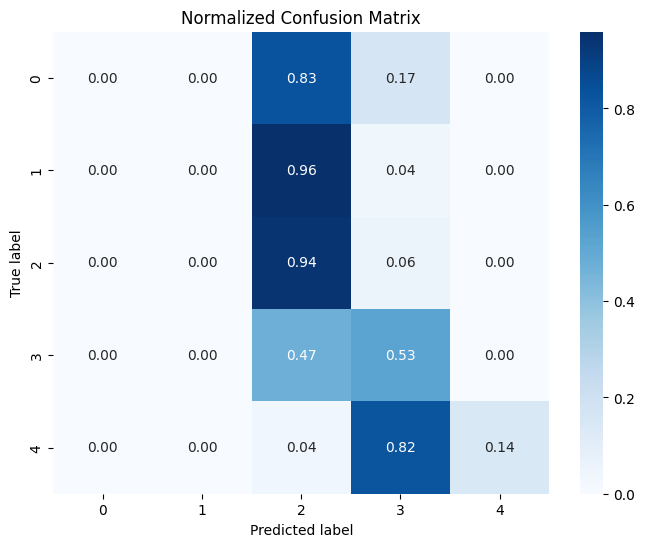

In [318]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_matrix, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
classes = np.unique(np.concatenate((y_test, y_pred)))

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, classes, normalize=True, title='Normalized Confusion Matrix')
